# Project Description


Detecting Pediatric Acute Lymphoblastic Leukemia using Computer Vision

https://omdena.com/chapter-challenges/detecting-pediatric-acute-lymphoblastic-leukemia-using-computer-vision/

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Required Packages

In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.6 MB/s eta 0:00:00


# Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
  

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import optuna




# Load Data - Batch 5



In [4]:
!unzip '/content/drive/MyDrive/omdena_liverpool_all/C-NMC_Leukemia/training_test_pickle/new_batch_5.zip'

Archive:  /content/drive/MyDrive/omdena_liverpool_all/C-NMC_Leukemia/training_test_pickle/new_batch_5.zip
 extracting: class labels.txt        
  inflating: test_Features.pickle    
  inflating: train_Features.pickle   


In [5]:
df_train = pd.read_pickle('train_Features.pickle')
df_test = pd.read_pickle('test_Features.pickle')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11917 entries, 0 to 11916
Columns: 32769 entries, 0 to label
dtypes: float32(32768), int32(1)
memory usage: 1.5 GB


In [7]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,32759,32760,32761,32762,32763,32764,32765,32766,32767,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.558721,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.784874,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.718844,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.373778,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.796494,0.0,0.0,0


In [8]:
df_train.shape

(11917, 32769)

In [9]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,32759,32760,32761,32762,32763,32764,32765,32766,32767,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.495325,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.412729,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.932062,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.277521,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.453448,0.0,0.0,0


In [10]:
df_test.shape

(1794, 32769)

# Create X and y Data to Feed ML Models

In [11]:
X_train = np.array(df_train.iloc[:,:-1].copy())
y_train = np.array(df_train['label'].copy())

In [12]:
(X_train.shape, y_train.shape)

((11917, 32768), (11917,))

In [13]:
X_test = np.array(df_test.iloc[:,:-1].copy())
y_test = np.array(df_test['label'].copy())

In [14]:
(X_test.shape, y_test.shape)

((1794, 32768), (1794,))

# Feature Selection - ANOVA

REF: https://machinelearningmastery.com/feature-selection-with-numerical-input-data/

In [15]:
# feature selection
def select_features(X_train_, y_train_, X_test_, SelRate = 0.2):
    # configure to select most important
    kSel = int(round(X_train_.shape[1]*SelRate))
    fs = SelectKBest(score_func=f_classif, k=kSel)
    # learn relationship from training data
    fs.fit(X_train_, y_train_)
    # transform train input data
    X_train_fs = fs.transform(X_train_)
    # transform test input data
    X_test_fs = fs.transform(X_test_)
    return X_train_fs, X_test_fs, fs

In [ ]:
X_train_fs, X_test_fs, FeatSel = select_features(X_train, y_train, X_test, 0.30)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    0     1     2 ... 32764 32766 32767] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
X_train = X_train_fs.copy()

In [ ]:
X_test = X_test_fs.copy()

In [ ]:
(X_train.shape, X_test.shape)

((11917, 9830), (1794, 9830))

# Classification - Logistic Regression

In [ ]:
clf_lreg = LogisticRegression(max_iter=1000000).fit(X_train, y_train)
y_pred = clf_lreg.predict(X_test)

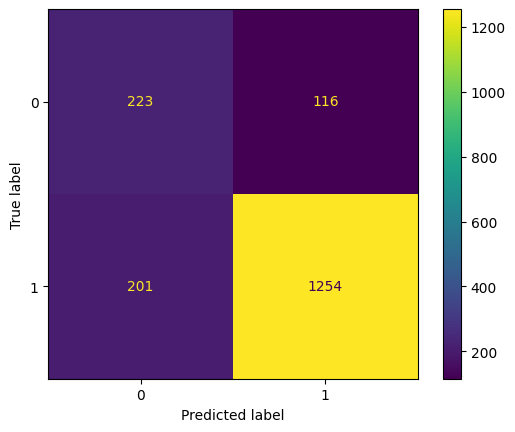

In [ ]:
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, clf_lreg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      6100
           1       0.88      0.93      0.90      5817

    accuracy                           0.90     11917
   macro avg       0.90      0.90      0.90     11917
weighted avg       0.90      0.90      0.90     11917



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.66      0.58       339
           1       0.92      0.86      0.89      1455

    accuracy                           0.82      1794
   macro avg       0.72      0.76      0.74      1794
weighted avg       0.84      0.82      0.83      1794



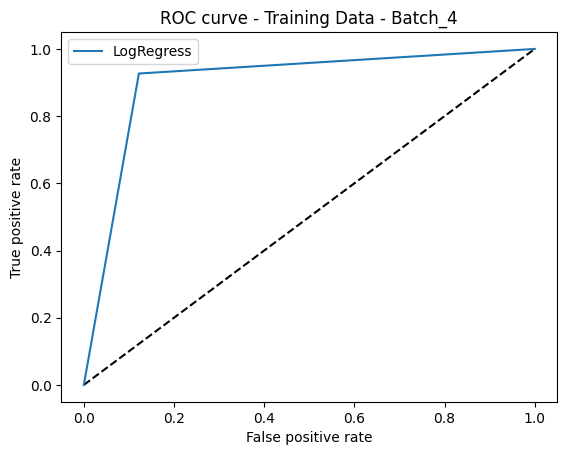

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_train, clf_lreg.predict(X_train))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='LogRegress')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Training Data - Batch_4')
plt.legend(loc='best')
plt.show()

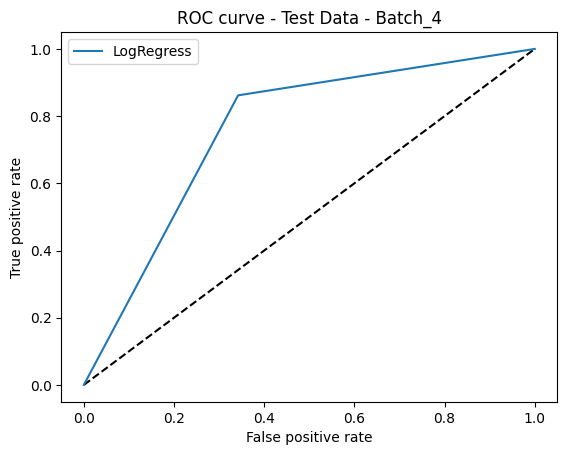

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, clf_lreg.predict(X_test))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='LogRegress')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data - Batch_4')
plt.legend(loc='best')
plt.show()

# Classification - Random Forest

In [ ]:
clf_RF = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
clf_RF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

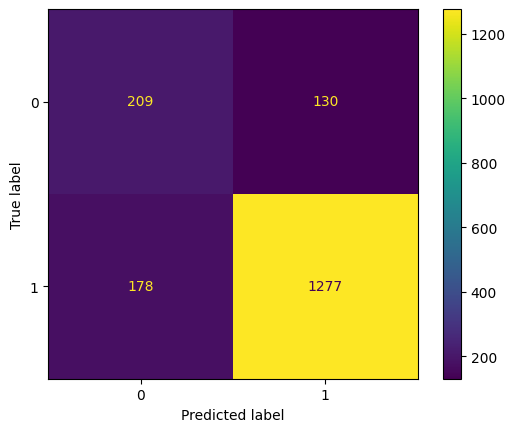

In [ ]:
y_pred = clf_RF.predict(X_test)
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, clf_RF.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6100
           1       1.00      1.00      1.00      5817

    accuracy                           1.00     11917
   macro avg       1.00      1.00      1.00     11917
weighted avg       1.00      1.00      1.00     11917



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.62      0.58       339
           1       0.91      0.88      0.89      1455

    accuracy                           0.83      1794
   macro avg       0.72      0.75      0.73      1794
weighted avg       0.84      0.83      0.83      1794



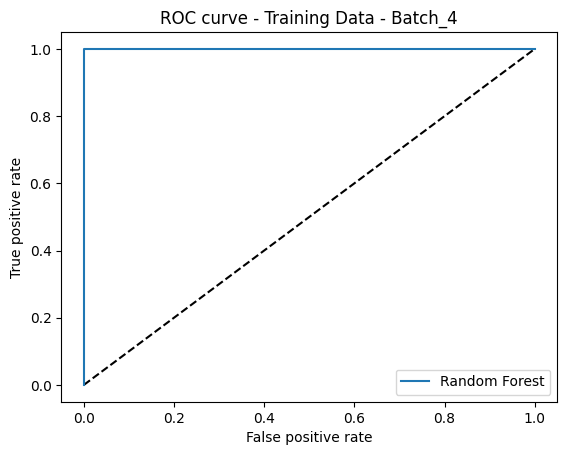

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_train, clf_RF.predict(X_train))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Training Data - Batch_4')
plt.legend(loc='best')
plt.show()

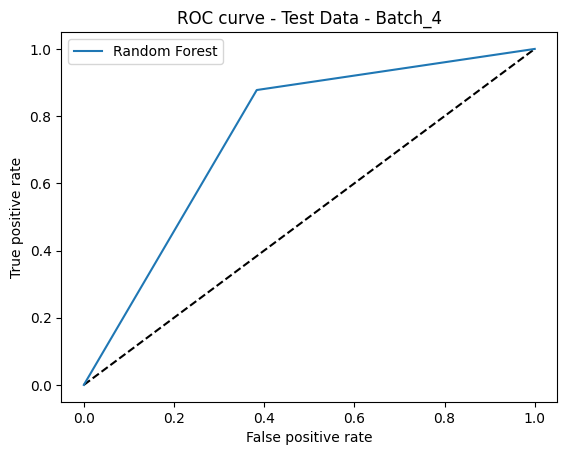

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, clf_RF.predict(X_test))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data - Batch_4')
plt.legend(loc='best')
plt.show()

# Classification - XGBoost

In [ ]:
clf_xgb = XGBClassifier(use_label_encoder=False,eval_metric='logloss',max_depth=50,n_estimators=50,random_state=2023)
clf_xgb.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=2023, ...)

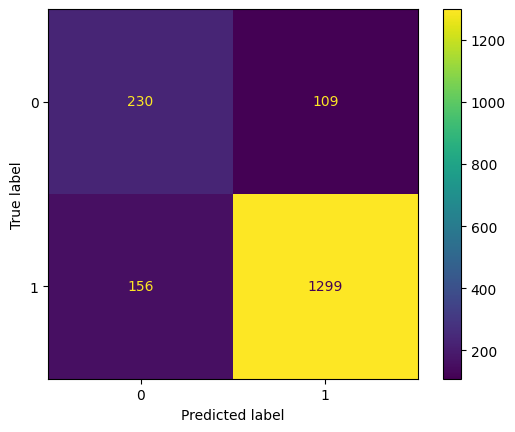

In [ ]:
y_pred = clf_xgb.predict(X_test)
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, clf_xgb.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6100
           1       1.00      1.00      1.00      5817

    accuracy                           1.00     11917
   macro avg       1.00      1.00      1.00     11917
weighted avg       1.00      1.00      1.00     11917



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.68      0.63       339
           1       0.92      0.89      0.91      1455

    accuracy                           0.85      1794
   macro avg       0.76      0.79      0.77      1794
weighted avg       0.86      0.85      0.86      1794



# Hyperparameter Tuning - Optuna


https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407


## Objective Function for Optuna - XGBoost

In [16]:
import xgboost as xgb

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    param = {
        'n_estimators'      : trial.suggest_int('n_estimators', 50, 500),
        'max_depth'         : trial.suggest_int('max_depth', 50, 500),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.001, 1),
        'verbosity'         : 1,
        'random_state'      : 42,
        'extra_trees'       : True,
        "objective"         : "binary:logistic",
        "eval_metric"       : "auc",
        "booster"           : trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda"            : trial.suggest_float("lambda", 1e-8, 1.0),
        "alpha"             : trial.suggest_float("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    return accuracy

## Run Optuna

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1000)

[I 2023-04-17 23:20:51,731] A new study created in memory with name: no-name-f2138cb2-c0d0-4717-838d-7e9e1f94f3c6


[23:21:02] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-04-17 23:21:16,155] Trial 0 finished with value: 0.18896321070234115 and parameters: {'n_estimators': 190, 'max_depth': 214, 'learning_rate': 0.08208776922739691, 'booster': 'gblinear', 'lambda': 0.9673760116834252, 'alpha': 0.3050869038648532}. Best is trial 0 with value: 0.18896321070234115.


[23:21:24] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.63633
[1]	validation-auc:0.65756
[2]	validation-auc:0.68693
[3]	validation-auc:0.69776
[4]	validation-auc:0.70087
[5]	validation-auc:0.70592
[6]	validation-auc:0.71309
[7]	validation-auc:0.72278
[8]	validation-auc:0.72602
[9]	validation-auc:0.73206


[I 2023-04-17 23:25:22,797] Trial 1 finished with value: 0.7597547380156076 and parameters: {'n_estimators': 308, 'max_depth': 384, 'learning_rate': 0.3645065685497786, 'booster': 'gbtree', 'lambda': 0.24734794369052593, 'alpha': 0.07406145074247926, 'eta': 0.36894531200611674, 'gamma': 0.8669672270246395, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7597547380156076.


[23:25:31] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-04-17 23:25:44,123] Trial 2 finished with value: 0.18896321070234115 and parameters: {'n_estimators': 302, 'max_depth': 202, 'learning_rate': 0.9688529919865255, 'booster': 'gblinear', 'lambda': 0.5124490273901813, 'alpha': 0.682065108263122}. Best is trial 1 with value: 0.7597547380156076.


[23:25:53] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.63296
[1]	validation-auc:0.64983
[2]	validation-auc:0.66080
[3]	validation-auc:0.66354
[4]	validation-auc:0.66896
[5]	validation-auc:0.67297
[6]	validation-auc:0.67856
[7]	validation-auc:0.68670
[8]	validation-auc:0.69471
[9]	validation-auc:0.70222


[I 2023-04-17 23:29:47,917] Trial 3 finished with value: 0.7240802675585284 and parameters: {'n_estimators': 370, 'max_depth': 433, 'learning_rate': 0.9653727607262917, 'booster': 'dart', 'lambda': 0.38645879788502213, 'alpha': 0.13884932747306805, 'eta': 0.9153495785929753, 'gamma': 0.16568936174794882, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.458291760134084, 'skip_drop': 0.5293504698202971}. Best is trial 1 with value: 0.7597547380156076.


[23:29:57] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "max_depth", "n_estimators" } are not used.

[0]	validation-auc:0.46362
[1]	validation-auc:0.46498
[2]	validation-auc:0.46590
[3]	validation-auc:0.46631
[4]	validation-auc:0.46657
[5]	validation-auc:0.46656
[6]	validation-auc:0.46690
[7]	validation-auc:0.46698
[8]	validation-auc:0.46695
[9]	validation-auc:0.46707


[I 2023-04-17 23:30:11,068] Trial 4 finished with value: 0.18896321070234115 and parameters: {'n_estimators': 238, 'max_depth': 412, 'learning_rate': 0.9141268663644253, 'booster': 'gblinear', 'lambda': 0.31918899506205245, 'alpha': 0.03137734825408746}. Best is trial 1 with value: 0.7597547380156076.


[23:30:20] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.62884
[1]	validation-auc:0.65415
[2]	validation-auc:0.67028
[3]	validation-auc:0.67480
[4]	validation-auc:0.68366
[5]	validation-auc:0.70041
[6]	validation-auc:0.70882
[7]	validation-auc:0.71733
[8]	validation-auc:0.72171
[9]	validation-auc:0.73084


[I 2023-04-17 23:33:58,906] Trial 5 finished with value: 0.7647714604236343 and parameters: {'n_estimators': 160, 'max_depth': 123, 'learning_rate': 0.6221832558520605, 'booster': 'gbtree', 'lambda': 0.6177389004394994, 'alpha': 0.15845539702031516, 'eta': 0.06505940976974885, 'gamma': 0.4202937902337162, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.7647714604236343.


[23:34:09] WARNING: ../src/learner.cc:767: 
Parameters: { "extra_trees", "n_estimators" } are not used.

[0]	validation-auc:0.62054
[1]	validation-auc:0.65078
[2]	validation-auc:0.68257
[3]	validation-auc:0.69053
[4]	validation-auc:0.70014
[5]	validation-auc:0.70627
[6]	validation-auc:0.71405
[7]	validation-auc:0.71537
[8]	validation-auc:0.72213
[9]	validation-auc:0.73104


[I 2023-04-17 23:38:06,520] Trial 6 finished with value: 0.7463768115942029 and parameters: {'n_estimators': 58, 'max_depth': 89, 'learning_rate': 0.5134100176716946, 'booster': 'gbtree', 'lambda': 0.9052107512195132, 'alpha': 0.21681031836009843, 'eta': 0.10204895248015053, 'gamma': 0.07244785457831256, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.7647714604236343.


## Best XGBoost Model from Optuna

In [19]:
study.best_params

{'n_estimators': 160,
 'max_depth': 123,
 'learning_rate': 0.6221832558520605,
 'booster': 'gbtree',
 'lambda': 0.6177389004394994,
 'alpha': 0.15845539702031516,
 'eta': 0.06505940976974885,
 'gamma': 0.4202937902337162,
 'grow_policy': 'lossguide'}

In [20]:
clf_xgb_opt= XGBClassifier(**study.best_params)

In [21]:
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(alpha=0.15845539702031516, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06505940976974885,
              eval_metric=None, feature_types=None, gamma=0.4202937902337162,
              gpu_id=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, lambda=0.6177389004394994,
              learning_rate=0.6221832558520605, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=123, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=160, n_jobs=None, ...)

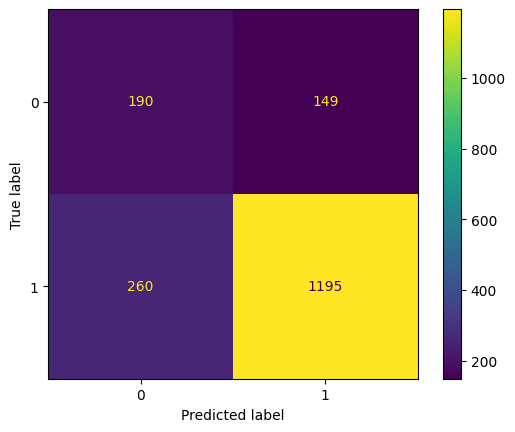

In [22]:
y_pred = clf_xgb_opt.predict(X_test)
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, clf_xgb_opt.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6100
           1       1.00      1.00      1.00      5817

    accuracy                           1.00     11917
   macro avg       1.00      1.00      1.00     11917
weighted avg       1.00      1.00      1.00     11917



In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.56      0.48       339
           1       0.89      0.82      0.85      1455

    accuracy                           0.77      1794
   macro avg       0.66      0.69      0.67      1794
weighted avg       0.80      0.77      0.78      1794



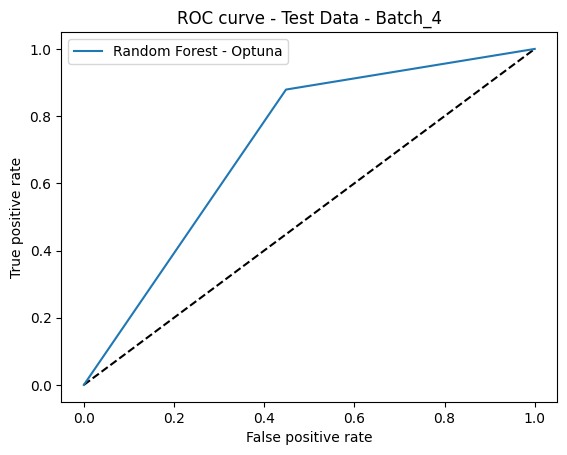

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, clf_xgb_opt.predict(X_test))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest - Optuna')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data - Batch_4')
plt.legend(loc='best')
plt.show()

In [24]:
import pickle

pickle.dump(clf_xgb_opt, open("Xgboost_Optuna_batch-5_All-Features_wallace_2023-04-17.pickle", "wb"))